In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import warnings

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
'''Main simulation function'''

def Ising(L, thermalization_steps, beta):
  N = L * L
  #Generate a square lattice with random spins
  lattice = np.random.choice(np.array([-1,1]),size=(L,L))

  #Perform thermalization loop
  for step in range(thermalization_steps):

    for spin in range(N):
      decide_on_spin_flip(L, lattice, beta)

  #Calculate correlation for a given r
  #We want to have it as a function of r
  #Divide by number of rows and number of columns to get average
  def correlation(r):
    corr = np.sum(lattice * np.roll(lattice, r))/(L ** 2)
    return corr

  #When the loop is done
  return lattice, correlation

In [ ]:
'''Metropolis algorithm'''

@jit(nopython=True)
def decide_on_spin_flip(L, lattice, beta):
  #Choose coordinates of one random spin from the square lattice
  x, y = np.random.randint(0, L), np.random.randint(0, L)

  #Sum all neighboring spins
  nearest_neighbor = lattice[(x-1)%L, y] + lattice[(x+1)%L, y] + lattice[x, (y-1)%L] + lattice[x, (y+1)%L]

  #Compute a difference of energy between the two configurations of spin
  delta = 2 * J * lattice[x, y] * nearest_neighbor

  #Calculate threshold probability
  p = np.exp(-beta * delta)

  #Draw a random number representing probability
  r = np.random.random()

  #Decide on spin flip
  if delta > 0:
    if r < p:
      lattice[x, y] *= -1
  elif delta <= 0:
    lattice[x, y] *= - 1

In [ ]:
'''Simulation parameters initialization'''

L = 500 #size of the lattice
T = 2 #a set of temperatures
kB = 1 #Boltzmann constant
beta = 1 / (kB * T)
J = 1 #Energy scale
thermalization_steps = np.array([10, 100, 1000, 5000])

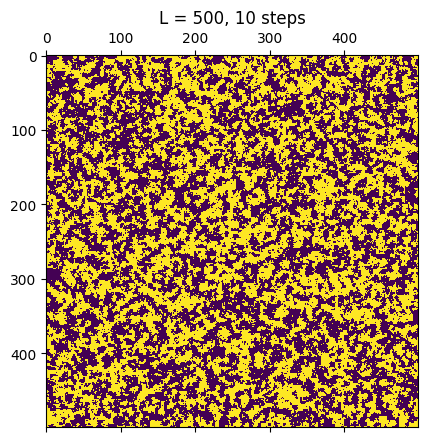

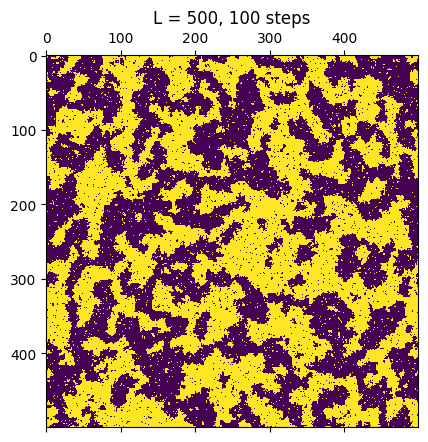

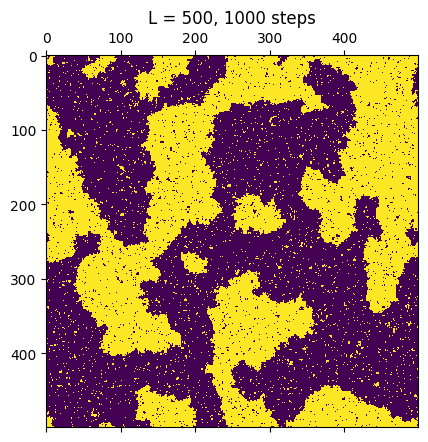

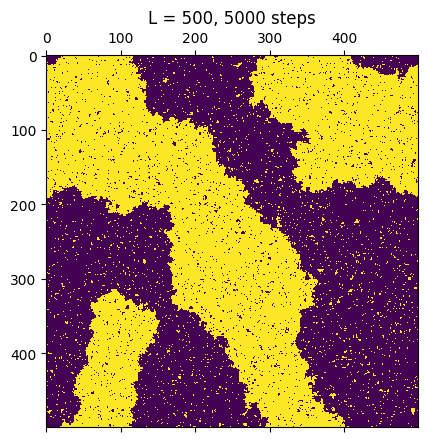

In [ ]:
'''Code demo and plotting'''

for _ in thermalization_steps:
  lattice = Ising(L, _, beta)[0]
  plt.matshow(lattice, fignum=None, interpolation='nearest')
  plt.title(f'L = {L}, {_} steps')
  plt.savefig(f"/content/gdrive/MyDrive/5SEM/SIM/images/Metropolis/Metropolis{_}.png", dpi=200)

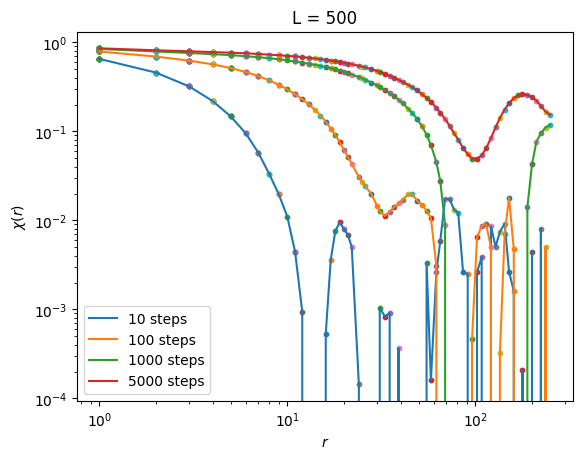

In [ ]:
'''Correlation function plotting'''

r = np.geomspace(1, L//2, num=100, dtype=int)

for steps in thermalization_steps:
  lattice, correlation = Ising(L, steps, beta)
  correlations = []

  plt.title(f'L = {L}')
  plt.xscale('log')
  plt.yscale('log')

  for _ in r:
    correlations += [correlation(_)]
    plt.scatter(_, correlation(_), s=10)

  plt.xlabel(r'$r$')
  plt.ylabel(r'$\chi (r)$')
  plt.plot(r, correlations, label=f'{steps} steps')
  plt.legend()
  plt.savefig(f"/content/gdrive/MyDrive/5SEM/SIM/images/Metropolis/Correlation{steps}.png", dpi=200)


plt.show()

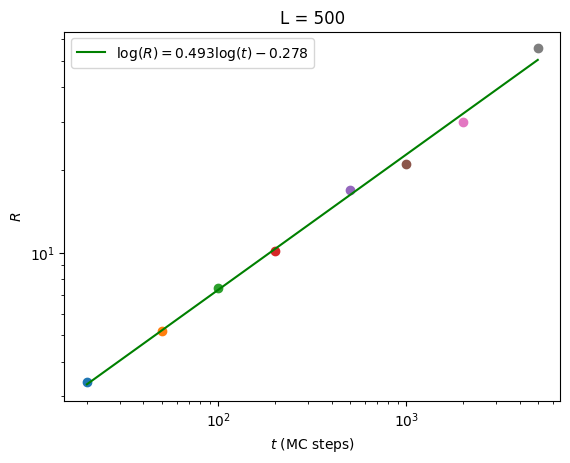

In [ ]:
r = np.arange(0, 250, 1)
R_arr = []

for steps in np.array([20, 50, 100, 200, 500, 1000, 2000, 5000]):
  correlation = Ising(L, steps, beta)[1]
  correlations = []

  plt.title(f'L = {L}')
  plt.xscale('log')
  plt.yscale('log')

  correlations = [correlation(val) for val in r]
  correlations = np.array(correlations)

  large_cor = correlations[correlations > 0.3]

  r_indices_large_cor = np.nonzero(large_cor)
  r_large = r[r_indices_large_cor]

  r_max = r_large[-1]

  sum = 0
  for _ in r_large:
    sum += np.log(abs(correlation(_)))

  with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    C = - sum
    R = r_max * (r_max + 1)/(2 * C)
    R_arr += [R]

  plt.xlabel(r'$t$ (MC steps)')
  plt.ylabel(r'$R$')
  plt.scatter(steps, R)

(a, b) = np.polyfit(np.log(np.array([20, 50, 100, 200, 500, 1000, 2000, 5000])), np.log(R_arr), deg=1)
plt.plot(np.array([20, 50, 100, 200, 500, 1000, 2000, 5000]), np.array([20, 50, 100, 200, 500, 1000, 2000, 5000]) ** a * np.exp(b), 'g', label=f'$\log(R) = {round(a, 3)} \log(t) {round(b, 3)}$')
plt.legend()

plt.savefig(f"/content/gdrive/MyDrive/5SEM/SIM/images/Metropolis/DomainSize.png", dpi=200)
plt.show()